In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [2]:
train = pd.read_csv('Train.csv')
train.head()

,Period_No,Facility_No,Facility_Category,City_Zip_Code,Operational_Region_Coverage_Area,Billing_Amount,Labelled_Price,Custom_Promoted,Promoted,Search_Promotions,Orders_Count,Course,Flavour_Profile
0,1,324,c1,977,169,192.955562,267.971749,0,0,0,123,Finger Foods,Asian Fusion
1,1,10,c3,0,62,193.384864,203.836706,0,0,0,55,Broths & Stews,Asian Fusion
2,1,99,c3,0,167,384.988183,388.957411,0,0,0,204,Smoothies & Juices,Western
3,1,95,c3,17,2,255.251864,263.923874,0,0,0,257,Grain Bowls,South Asian
4,1,128,c3,17,18,319.949514,326.128813,0,0,0,14,Appetizers,Asian Fusion


In [3]:
train.shape

(321437, 13)

In [4]:
train.isnull().sum()

Period_No                           0
Facility_No                         0
Facility_Category                   0
City_Zip_Code                       0
Operational_Region_Coverage_Area    0
Billing_Amount                      0
Labelled_Price                      0
Custom_Promoted                     0
Promoted                            0
Search_Promotions                   0
Orders_Count                        0
Course                              0
Flavour_Profile                     0
dtype: int64

In [5]:
train.duplicated().sum()

0

In [6]:
train.describe()

,Period_No,Facility_No,City_Zip_Code,Operational_Region_Coverage_Area,Billing_Amount,Labelled_Price,Custom_Promoted,Promoted,Search_Promotions,Orders_Count
count,321437.000000,321437.000000,321437.000000,321437.000000,321437.000000,321437.000000,321437.000000,321437.000000,321437.000000,321437.000000
mean,50.054129,420.232991,271.276987,418.082445,331.620562,362.638131,0.083018,0.108236,0.066968,261.533790
std,28.779770,1575.034508,403.842530,2662.500716,154.058035,163.467156,0.275910,0.310679,0.249967,383.785233
min,1.000000,3.000000,0.000000,1.000000,51.211374,59.937296,0.000000,0.000000,0.000000,13.000000
25%,25.000000,36.000000,0.000000,13.000000,223.793489,249.052171,0.000000,0.000000,0.000000,54.000000
50%,50.000000,78.000000,17.000000,48.000000,297.266165,318.979959,0.000000,0.000000,0.000000,136.000000
75%,75.000000,132.000000,582.000000,140.000000,441.947052,471.092392,0.000000,0.000000,0.000000,324.000000
max,100.000000,12390.000000,977.000000,23595.000000,864.305642,876.832957,1.000000,1.000000,1.000000,13150.000000


In [7]:
test = pd.read_csv('Test.csv')
test.head()

,Period_No,Facility_No,Facility_Category,City_Zip_Code,Operational_Region_Coverage_Area,Billing_Amount,Labelled_Price,Custom_Promoted,Promoted,Search_Promotions,Course,Flavour_Profile
0,101,56,c1,0,1,139.958249,169.692414,0,0,0,Smoothies & Juices,Asian Fusion
1,101,5,c2,977,23595,326.909659,333.530773,0,0,0,Fresh Greens,Mediterranean
2,101,988,c2,17,2,320.866835,328.095148,0,0,0,Smoothies & Juices,Western
3,101,36,c2,0,12,469.922362,476.656331,0,0,0,Smoothies & Juices,Western
4,101,24,c1,0,66,248.252845,326.033774,0,0,0,Grain Bowls,South Asian


In [8]:
test.shape

(118070, 12)

In [9]:
test.isnull().sum()

Period_No                           0
Facility_No                         0
Facility_Category                   0
City_Zip_Code                       0
Operational_Region_Coverage_Area    0
Billing_Amount                      0
Labelled_Price                      0
Custom_Promoted                     0
Promoted                            0
Search_Promotions                   0
Course                              0
Flavour_Profile                     0
dtype: int64

In [10]:
test.duplicated().sum()

0

In [11]:
combined = pd.concat([train, test], axis = 0)
combined.shape

(439507, 13)

In [12]:
combined['Facility_No'].value_counts()

Facility_No
63       6784
13       6753
87       6737
112      6708
36       6663
         ... 
128      4461
67       4347
126      4197
12390    3926
876      3307
Name: count, Length: 77, dtype: int64

In [13]:
numerical_columns = combined[['Billing_Amount', 'Labelled_Price', 'Orders_Count']]

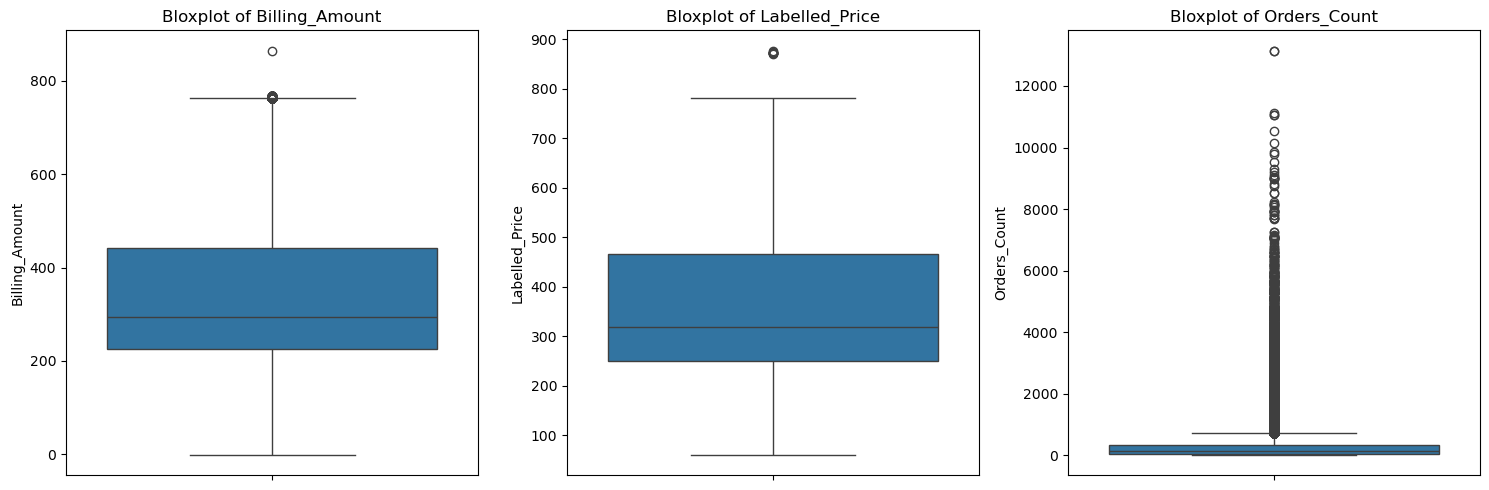

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes = axes.flatten()

for i, col in enumerate(numerical_columns.columns):
    sns.boxplot(data = combined, y=col, ax=axes[i])
    axes[i].set_title(f'Bloxplot of {col}')

plt.tight_layout()
plt.show()

In [15]:
def replace_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1-1.5*iqr
    upper = q3+1.5*iqr
    median_value = df[column].median()
    df[column] = np.where((df[column]<lower)|(df[column]>upper), median_value, df[column])
    return df

In [16]:
for col in numerical_columns.columns:
    concat_df = replace_outliers(combined, col)

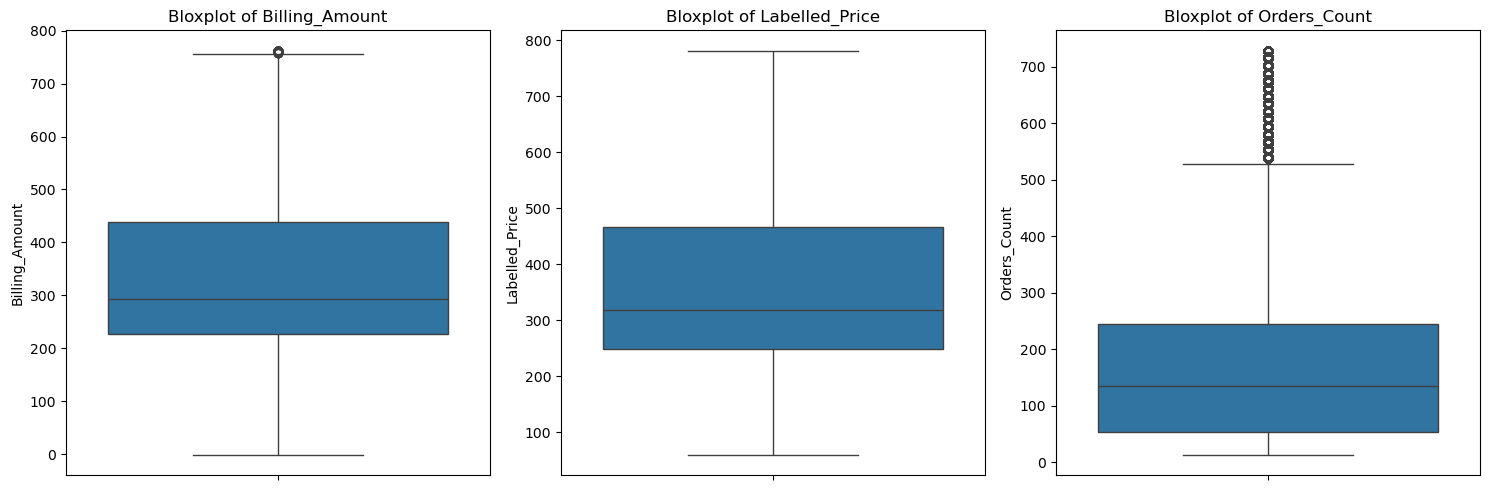

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes = axes.flatten()

for i, col in enumerate(numerical_columns.columns):
    sns.boxplot(data = combined, y=col, ax=axes[i])
    axes[i].set_title(f'Bloxplot of {col}')

plt.tight_layout()
plt.show()

In [18]:
reference_date = pd.Timestamp('2020-01-01')  
combined['Period_Date'] = reference_date + pd.to_timedelta(combined['Period_No'] - 1, unit='W')

In [19]:
combined['Day_of_Week'] = combined['Period_Date'].dt.dayofweek 
combined['Month'] = combined['Period_Date'].dt.month  

In [20]:
combined.head()

,Period_No,Facility_No,Facility_Category,City_Zip_Code,Operational_Region_Coverage_Area,Billing_Amount,Labelled_Price,Custom_Promoted,Promoted,Search_Promotions,Orders_Count,Course,Flavour_Profile,Period_Date,Day_of_Week,Month
0,1,324,c1,977,169,192.955562,267.971749,0,0,0,123.0,Finger Foods,Asian Fusion,2020-01-01,2,1
1,1,10,c3,0,62,193.384864,203.836706,0,0,0,55.0,Broths & Stews,Asian Fusion,2020-01-01,2,1
2,1,99,c3,0,167,384.988183,388.957411,0,0,0,204.0,Smoothies & Juices,Western,2020-01-01,2,1
3,1,95,c3,17,2,255.251864,263.923874,0,0,0,257.0,Grain Bowls,South Asian,2020-01-01,2,1
4,1,128,c3,17,18,319.949514,326.128813,0,0,0,14.0,Appetizers,Asian Fusion,2020-01-01,2,1


In [21]:
combined["Facility_count"] = combined.groupby("Facility_No")["Orders_Count"].transform('count')
combined["Facility_mean"] = combined.groupby("Facility_No")["Orders_Count"].transform('mean')
combined["Facility_median"] = combined.groupby("Facility_No")["Orders_Count"].transform('median')
combined["Facility_min"] = combined.groupby("Facility_No")["Orders_Count"].transform('min')
combined["Facility_max"] = combined.groupby("Facility_No")["Orders_Count"].transform('max')
combined["Facility_std"] = combined.groupby("Facility_No")["Orders_Count"].transform('std')

In [22]:
combined["Zipcode_count"] = combined.groupby("City_Zip_Code")["Orders_Count"].transform('count')
combined["Zipcode_mean"] = combined.groupby("City_Zip_Code")["Orders_Count"].transform('mean')
combined["Zipcode_median"] = combined.groupby("City_Zip_Code")["Orders_Count"].transform('median')
combined["Zipcode_min"] = combined.groupby("City_Zip_Code")["Orders_Count"].transform('min')
combined["Zipcode_max"] = combined.groupby("City_Zip_Code")["Orders_Count"].transform('max')
combined["Zipcode_std"] = combined.groupby("City_Zip_Code")["Orders_Count"].transform('std')

In [23]:
combined["Operational_count"] = combined.groupby("Operational_Region_Coverage_Area")["Orders_Count"].transform('count')
combined["Operational_mean"] = combined.groupby("Operational_Region_Coverage_Area")["Orders_Count"].transform('mean')
combined["Operational_median"] = combined.groupby("Operational_Region_Coverage_Area")["Orders_Count"].transform('median')
combined["Operational_min"] = combined.groupby("Operational_Region_Coverage_Area")["Orders_Count"].transform('min')
combined["Operational_max"] = combined.groupby("Operational_Region_Coverage_Area")["Orders_Count"].transform('max')
combined["Operational_std"] = combined.groupby("Operational_Region_Coverage_Area")["Orders_Count"].transform('std')

In [24]:
max_period = 12
combined['sin_period'] = np.sin(2 * np.pi * combined['Period_No'] / max_period)
combined['cos_period'] = np.cos(2 * np.pi * combined['Period_No'] / max_period)

In [25]:
le = LabelEncoder()
x = ['Facility_Category', 'Course', 'Flavour_Profile']
for i in x:
    combined[i] = le.fit_transform(combined[i])

In [26]:
combined = combined.drop(['Period_Date','Period_No'], axis = 1)

In [27]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 439507 entries, 0 to 118069
Data columns (total 34 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Facility_No                       439507 non-null  int64  
 1   Facility_Category                 439507 non-null  int32  
 2   City_Zip_Code                     439507 non-null  int64  
 3   Operational_Region_Coverage_Area  439507 non-null  int64  
 4   Billing_Amount                    439507 non-null  float64
 5   Labelled_Price                    439507 non-null  float64
 6   Custom_Promoted                   439507 non-null  int64  
 7   Promoted                          439507 non-null  int64  
 8   Search_Promotions                 439507 non-null  int64  
 9   Orders_Count                      321437 non-null  float64
 10  Course                            439507 non-null  int32  
 11  Flavour_Profile                   439507 non-null  int32 

In [55]:
newtrain = combined.iloc[0:321437, :]
newtest = combined.iloc[321437:, :].drop('Orders_Count', axis = 1)

In [57]:
newtrain.head()

,Facility_No,Facility_Category,City_Zip_Code,Operational_Region_Coverage_Area,Billing_Amount,Labelled_Price,Custom_Promoted,Promoted,Search_Promotions,Orders_Count,...,Zipcode_max,Zipcode_std,Operational_count,Operational_mean,Operational_median,Operational_min,Operational_max,Operational_std,sin_period,cos_period
0,324,0,977,169,192.955562,267.971749,0,0,0,123.0,...,729.0,156.705279,18103,182.922720,136.0,13.0,729.0,168.772129,0.5,0.866025
1,10,2,0,62,193.384864,203.836706,0,0,0,55.0,...,729.0,171.715712,36987,170.346852,122.0,13.0,729.0,161.380973,0.5,0.866025
2,99,2,0,167,384.988183,388.957411,0,0,0,204.0,...,729.0,171.715712,6653,137.408838,94.0,13.0,729.0,134.514054,0.5,0.866025
3,95,2,17,2,255.251864,263.923874,0,0,0,257.0,...,729.0,153.586343,7575,193.982178,136.0,13.0,729.0,168.346420,0.5,0.866025
4,128,2,17,18,319.949514,326.128813,0,0,0,14.0,...,729.0,153.586343,17767,152.919401,107.0,13.0,729.0,150.682852,0.5,0.866025


In [59]:
newtrain.shape

(321437, 34)

In [61]:
newtest.head()

,Facility_No,Facility_Category,City_Zip_Code,Operational_Region_Coverage_Area,Billing_Amount,Labelled_Price,Custom_Promoted,Promoted,Search_Promotions,Course,...,Zipcode_max,Zipcode_std,Operational_count,Operational_mean,Operational_median,Operational_min,Operational_max,Operational_std,sin_period,cos_period
0,56,0,0,1,139.958249,169.692414,0,0,0,10,...,729.0,171.715712,18304,196.264041,136.0,13.0,729.0,168.933168,0.5,-0.866025
1,5,1,977,23595,326.909659,333.530773,0,0,0,5,...,729.0,156.705279,4171,223.836250,175.0,13.0,729.0,166.663153,0.5,-0.866025
2,988,1,17,2,320.866835,328.095148,0,0,0,10,...,729.0,153.586343,7575,193.982178,136.0,13.0,729.0,168.346420,0.5,-0.866025
3,36,1,0,12,469.922362,476.656331,0,0,0,10,...,729.0,171.715712,19283,202.773427,136.0,13.0,729.0,175.744965,0.5,-0.866025
4,24,0,0,66,248.252845,326.033774,0,0,0,6,...,729.0,171.715712,4794,210.464330,136.0,13.0,729.0,186.381172,0.5,-0.866025


In [63]:
newtest.shape

(118070, 33)

In [65]:
x = newtrain.drop('Orders_Count', axis = 1)
y = newtrain['Orders_Count']

In [67]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [69]:
models = {'Logistic Regression': LinearRegression(), 'Random Forest': RandomForestRegressor(),
         'Bagging': BaggingRegressor(), 'Extra Tree': ExtraTreesRegressor(), 'LightGBM': LGBMRegressor(),
         'Gradient Boosting': GradientBoostingRegressor(), 'Adaboost': AdaBoostRegressor(),
         'XGB': XGBRegressor()}

In [71]:
def evaluate_models(x_train, x_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        predictions = model.fit(x_train, y_train).predict(x_test)
        accuracy = np.sqrt(mean_squared_error(y_test, predictions))
        results[name] = accuracy
    return results

In [73]:
results = evaluate_models(x_train, x_test, y_train, y_test, models)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 257149, number of used features: 29
[LightGBM] [Info] Start training from score 178.339192


In [74]:
best_model_name = min(results, key = results.get)
best_model = models[best_model_name]

In [75]:
print(f"best model is {best_model_name} with rmse {results[best_model_name]}")

best model is Random Forest with rmse 104.15663075243538


In [76]:
y_pred = best_model.fit(x_train, y_train).predict(x_test)

In [77]:
print(np.sqrt(mean_squared_error(y_test, y_pred)))

104.14941536402368


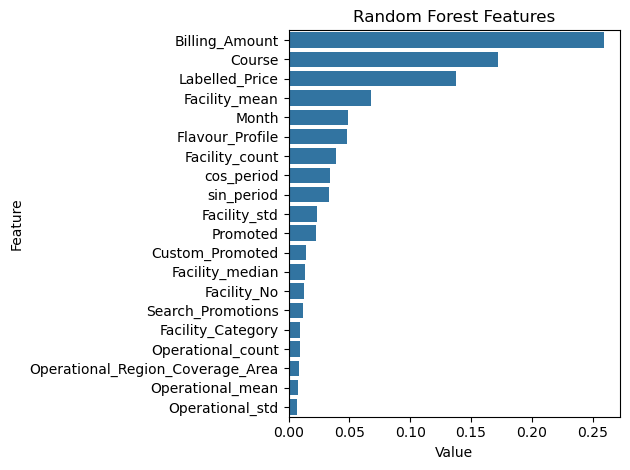

In [78]:
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_, x.columns), reverse=True)[:20], columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title(f'{best_model_name} Features')
plt.tight_layout()
plt.show()


In [79]:
x_train = newtrain.drop('Orders_Count', axis = 1)
y_train = newtrain['Orders_Count']
x_test = newtest
y_pred = best_model.fit(x_train, y_train).predict(x_test)

In [80]:
solution = pd.DataFrame({'Orders_Count': y_pred})
solution.head()

,Orders_Count
0,213.48
1,450.29
2,55.31
3,64.82
4,203.27


In [81]:
solution.to_csv('Solution.csv', index = False)